**Executed:** Mon Oct  3 22:33:58 2016

**Duration:** 5 seconds.

# usALEX - Corrections - Direct excitation physical parameter

> *This notebook estimates direct excitation coefficient $d_{dirT}$ from μs-ALEX data.*

# Definitions Memo

$$n_d = I_{D_{ex}} \, \sigma_{D_{ex}}^D \,
\phi_D \, \eta_{D_{det}}^{D_{em}} \, (1-E)$$

$$n_a = I_{D_{ex}} \, \sigma_{D_{ex}}^D \,
\phi_A \, \eta_{A_{det}}^{A_{em}} \, E$$

$$ n_{aa} = I_{A_{ex}} \, \sigma_{A_{ex}}^A \,
\phi_A \, \eta_{A_{det}}^{A_{em}}$$

$$n_a^* = n_a + Lk + Dir$$

where

$$Lk = I_{D_{ex}} \, \sigma_{D_{ex}}^D \,
\phi_D \, \eta_{A_{det}}^{D_{em}} \, (1-E)$$

$$Dir = I_{D_{ex}} \, \sigma_{D_{ex}}^A \,
\phi_A \, \eta_{A_{det}}^{A_{em}}$$

$$\gamma = \frac{\phi_A\,\eta_{D_{det}}^{A_{em}}}{\phi_D\,\eta_{D_{det}}^{D_{em}}}$$

# Aim of this notebook

## What is already computed?

We previously fitted the **leakage** and **gamma** coefficient from the RAW PR values 
for the 5 dsDNA measurements. We also fitted the
direct excitation coefficient expressed (`dir_ex_aa`) as a function of the 
A-signal during A-excitation (`naa`). In symbols, `dir_ex_aa` is defined as:

$$ d_{dirAA} = \frac{n_{a}}{n_{aa}}$$

for a A-only population.

## What we want to compute?

Alternatively, we can express the direct excitation contribution ($Dir$)
as a function of the total corrected burst size:

$$ Dir = d_{dirT}\, (n_a + \gamma n_d)$$

With this definition, expressing $d_{dirT}$ as a function 
of the physical parameters we obtain:

$$d_{dirT} = \frac{\sigma_{D_{ex}}^A}{\sigma_{D_{ex}}^D} $$

where $\sigma_{Dex}^A$ and $\sigma_{Dex}^D$ are the absorption cross-sections 
of the Acceptor and Donor dye at wavelength of Donor laser.

Finally, remembering the definition of $\beta$:

$$ \beta = \frac{I_{A_{ex}}\sigma_{A_{ex}}^A}{I_{D_{ex}}\sigma_{D_{ex}}^D}$$

we can express $d_{dirT}$ as the product of $\beta$ and $d_{dirAA}$:

$$ d_{dirT} = \beta \, d_{dirAA}$$

Note that $d_{dirT}$ is a property of the Donor-Acceptor dyes pair and of the
Donor excitation wavelength. As such, differently from $d_{dirAA}$, the 
$d_{dirT}$ coefficient is valid for the same sample in any setup using the same
donor excitation wavelength, such as the single-spot μs-ALEX and the multi-spot
system. Additionally, $d_{dirT}$ allows to correct for direct acceptor
excitation using only donor-excitation quantities. Therefore the same
correction formula can be used both in two-laser (e.g. single-spot μs-ALEX) 
and single-laser systems (e.g. 8-spot system).

## How we compute it?

We use two different procedures both yielding
an estimation of $d_{dirT}$. Except for the numerical
accuracy the two procedures are equivalent.

### Procedure 1: Using beta

From the previous relation between $d_{dirT} = \beta \,d_{dirAA}$ is possible to
directly estimate $d_{dirT}$ with the values of $\beta$ and $d_{dirAA}$
we already fitted in previous notebooks.

### Procedure 2: Correction formula

It is possible to go from the raw $E_R$ (only background correction, 
no leakage, direct excitation nor gamma) to the fully-corrected $E$
using the formula:

$$ E = f(E_R,\, \gamma,\, L_k,\, d_{dirT}) = 
\frac{E_{R} \left(L_{k} + d_{dirT} \gamma + 1\right) - L_{k} - d_{dirT} \gamma}
{E_{R} \left(L_{k} - \gamma + 1\right) - L_{k} + \gamma}$$

* See [Derivation of FRET and S correction formulas](http://nbviewer.jupyter.org/github/tritemio/notebooks/blob/master/Derivation%20of%20FRET%20and%20S%20correction%20formulas.ipynb) for derivation.

We can compute the corrected $E$ for the 5 dsDNA samples by fitting
the fully-corrected histograms (histograms with γ, leakage and 
direct excitation corrections). We can also fit the 5 $E_R$ values 
for the same samples from the proximity ratio histograms 
(only background correction).

Therefore, using the previous formula we can fit $d_{dirT}$ (`dir_ex_t`)
by minimizing the error between the 5 $E$ values fitted from
corrected histograms and the 5 $E$ values obtained correcting
the 5 $E_R$ values from the fit of the proximity ratio histograms.

# Loading data

We load the needed libraries and FRETBursts which includes the FRET
correction formulas ($E = f(E_R,\, \gamma,\, L_k,\, d_{dirT})$).

In [1]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import lmfit
from fretbursts import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'  # for hi-dpi displays
sns.set_style('whitegrid')

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


## Load Raw PR

In [2]:
#bsearch_ph_sel = 'AND-gate'
bsearch_ph_sel = 'Dex'

data_file = 'results/usALEX-5samples-PR-raw-%s.csv' % bsearch_ph_sel

These are the **RAW proximity ratios** for the 5 samples (only background correction, no leakage nor direct excitation):

In [3]:
data_raw = pd.read_csv(data_file).set_index('sample')
data_raw[['E_gauss_w', 'E_kde_w']]

,E_gauss_w,E_kde_w
sample,,
7d,0.927817,0.9338
12d,0.748896,0.7508
17d,0.480670,0.4906
22d,0.280392,0.2752
27d,0.194729,0.1944


## Load Corrected E

And these are the **FRET efficiencies** fitted from corrected histograms for the same 5 samples: 

In [4]:
data_file = 'results/usALEX-5samples-E-corrected-all-ph.csv'
data_corr = pd.read_csv(data_file).set_index('sample')
data_corr[['E_gauss_w', 'E_kde_w']]

,E_gauss_w,E_kde_w
sample,,
7d,0.924307,0.9290
12d,0.727043,0.7398
17d,0.422624,0.4268
22d,0.181067,0.1774
27d,0.083971,0.0826


## Load SNA Data

In [5]:
data_file_sna = 'results/usALEX-5samples-E-SNA.csv'

In [6]:
sna = pd.read_csv(data_file_sna, index_col=0)
sna

,SNA_Epr_mean,SNA_Epr_max
Sample,,
7d,0.912,0.932
12d,0.718,0.730
17d,0.424,0.409
22d,0.170,0.162
27d,0.065,0.065


## Load μs-ALEX corrections

In [7]:
leakage_coeff_fname = 'results/usALEX - leakage coefficient DexDem.csv'
leakage = np.loadtxt(leakage_coeff_fname)

print('Leakage coefficient:', leakage)

Leakage coefficient: 0.10029


In [8]:
dir_ex_coeff_fname = 'results/usALEX - direct excitation coefficient dir_ex_aa.csv'
dir_ex_aa = np.loadtxt(dir_ex_coeff_fname)

print('Dir. excitation AA:', dir_ex_aa)

Dir. excitation AA: 0.06062


In [9]:
dir_ex_t_datasheet_fname = 'results/Dyes - ATT0647N-ATTO550 abs X-section ratio at 532nm.csv'
dir_ex_t_datasheet = np.loadtxt(dir_ex_t_datasheet_fname)

print('Direct excitation (dir_ex_t) from datasheet:', dir_ex_t_datasheet)

Direct excitation (dir_ex_t) from datasheet: 0.106516290727


In [10]:
gamma_coeff_fname = 'results/usALEX - gamma factor - all-ph.csv'
gamma = np.loadtxt(gamma_coeff_fname)

print('Gamma factor:', gamma)

Gamma factor: 1.020526


In [11]:
beta_coeff_fname = 'results/usALEX - beta factor - all-ph.csv'
beta = np.loadtxt(beta_coeff_fname)

print('Beta factor:', beta)

Beta factor: 0.813553


# Procedure 1

Compute $d_{dirT}$ using $\beta$ and $d_{dirAA}$:

In [12]:
dir_ex_t_beta = dir_ex_aa * beta
'%.5f' % dir_ex_t_beta

'0.04932'

In [13]:
with open('results/usALEX - direct excitation coefficient dir_ex_t beta.csv', 'w') as f:
    f.write('%.5f' % dir_ex_t_beta)

With this coefficient, computing the corrected $E$ for the 5 dsDNA samples
we obtain:

In [14]:
PR_corr_kde = fretmath.correct_E_gamma_leak_dir(data_raw.E_kde_w, 
                                                leakage=leakage, 
                                                dir_ex_t=dir_ex_t_beta,
                                                gamma=gamma)*100
PR_corr_kde

sample
7d     92.873302
12d    72.773077
17d    43.140290
22d    17.621842
27d     7.807774
Name: E_kde_w, dtype: float64

In [15]:
PR_corr_gauss = fretmath.correct_E_gamma_leak_dir(data_raw.E_gauss_w, 
                                                  leakage=leakage, 
                                                  dir_ex_t=dir_ex_t_beta,
                                                  gamma=gamma)*100
PR_corr_gauss

sample
7d     92.225478
12d    72.560799
17d    41.983996
22d    18.247880
27d     7.848009
Name: E_gauss_w, dtype: float64

# Procedure 2

## Datasheet-based direct excitation

The coefficient $d_{dirT}$ can be estimated from data-sheet values of 
$\sigma_{D_{ex}}^A$ and $\sigma_{D_{ex}}^D$.

Using the [datasheet values](dyes/Absorption ATTO550-ATTO647N.ipynb) 
provided by ATTOTec (in PBS buffer) we obtain a $d_{dirT}$ estimation
close to 10%:

In [16]:
dir_ex_t_datasheet

array(0.106516290727)

With this the corrected $E$ for the 5 dsDNA samples are:

In [17]:
E_datasheet = fretmath.correct_E_gamma_leak_dir(data_raw.E_kde_w, 
                                                leakage=leakage, 
                                                dir_ex_t=dir_ex_t_datasheet,
                                                gamma=gamma)*100
E_datasheet

sample
7d     92.484823
12d    71.288927
17d    40.040846
22d    13.131377
27d     2.782340
Name: E_kde_w, dtype: float64

Comparing these values with the ones obtained fitting the
corrected E histograms we observe a significant discrepancy:

In [18]:
out = data_corr[['E_kde_w']].copy()*100
out.columns = ['E_alex']
out['E_datasheet'] = E_datasheet
out

,E_alex,E_datasheet
sample,,
7d,92.90,92.484823
12d,73.98,71.288927
17d,42.68,40.040846
22d,17.74,13.131377
27d,8.26,2.782340


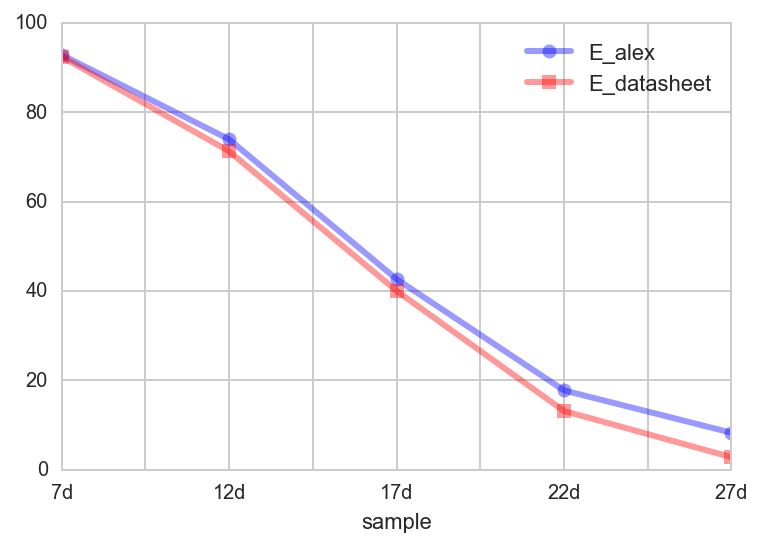

In [19]:
out.plot(alpha=0.4, lw=3, style=dict(E_alex='-ob', E_datasheet='-sr'));

> **NOTE:** The corrected FRET efficiencies using the datasheet and 
> μs-ALEX-based direct excitation do not match well.

## Fitting direct excitation $d_{dirT}$

In [20]:
def residuals_absolute(params, E_raw, E_ref):
    dir_ex_t = params['dir_ex_t'].value
    return E_ref - fretmath.correct_E_gamma_leak_dir(E_raw, 
                                                     leakage=leakage, 
                                                     gamma=gamma, 
                                                     dir_ex_t=dir_ex_t)

In [21]:
def residuals_relative(params, E_raw, E_ref):
    dir_ex_t = params['dir_ex_t'].value
    return (E_ref - fretmath.correct_E_gamma_leak_dir(E_raw, 
                                                      leakage=leakage, 
                                                      gamma=gamma, 
                                                      dir_ex_t=dir_ex_t))/E_ref

In [22]:
params = lmfit.Parameters()
params.add('dir_ex_t', value=0.05) 

In [23]:
m = lmfit.minimize(residuals_absolute, params, args=(data_raw.E_kde_w, data_corr.E_kde_w))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    dir_ex_t:   0.04614939 +/- 0.004939 (10.70%) (init= 0.05)


In [24]:
m = lmfit.minimize(residuals_relative, params, args=(data_raw.E_kde_w, data_corr.E_kde_w))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    dir_ex_t:   0.04482660 +/- 0.001150 (2.57%) (init= 0.05)


> **NOTE:** The fitted `dir_ex_t` is 4.5% as opposed to 10.6% as expected from the [absorption spectra of ATTO550 and ATTO647](dyes/Absorption ATTO550-ATTO647N.ipynb) at 532nm.

In [25]:
'%.5f' % m.params['dir_ex_t'].value

'0.04483'

In [26]:
with open('results/usALEX - direct excitation coefficient dir_ex_t fit.csv', 'w') as f:
    f.write('%.5f' % m.params['dir_ex_t'].value)

# Corrected E

In [27]:
data_raw

,n_bursts_all,n_bursts_do,n_bursts_fret,E_kde_w,E_gauss_w,E_gauss_w_sig,E_gauss_w_err,S_kde,S_gauss,S_gauss_sig,S_gauss_err,E_pr_do_kde,E_pr_do_hsm,E_pr_do_gauss,nt_mean
sample,,,,,,,,,,,,,,,
7d,1654,956,641,0.9338,0.927817,0.053928,0.002130,0.5750,0.576817,0.100866,0.003984,0.1000,0.090002,0.104080,23.042040
12d,1692,486,1157,0.7508,0.748896,0.083924,0.002467,0.5974,0.588508,0.104495,0.003072,0.0998,0.098139,0.102115,23.504845
17d,3459,766,2588,0.4906,0.480670,0.101775,0.002001,0.5740,0.583539,0.108368,0.002130,0.1054,0.120002,0.108943,23.063124
22d,2798,501,2181,0.2752,0.280392,0.067918,0.001454,0.5768,0.583358,0.110174,0.002359,0.0962,0.074235,0.104701,26.631819
27d,1146,316,792,0.1944,0.194729,0.057172,0.002032,0.5786,0.605397,0.108735,0.003864,0.0904,0.091578,0.093993,19.882093


In [28]:
PR_corr_kde_dfit = fretmath.correct_E_gamma_leak_dir(data_raw.E_kde_w, 
                                                     leakage=leakage, 
                                                     dir_ex_t=m.params['dir_ex_t'].value,
                                                     gamma=gamma)*100
PR_corr_kde_dfit.name = 'PR_corr_kde_dfit'
PR_corr_kde_dfit

sample
7d     92.903804
12d    72.889605
17d    43.383644
22d    17.974412
27d     8.202347
Name: PR_corr_kde_dfit, dtype: float64

In [29]:
E = pd.concat([data_corr[['E_kde_w', 'E_gauss_w']]*100, PR_corr_kde, PR_corr_gauss, sna*100], axis=1)
E.columns = ['E KDE', 'E Gauss', 'PR KDE', 'PR Gauss', 'SNA Epr mean', 'SNA Epr max']
E

,E KDE,E Gauss,PR KDE,PR Gauss,SNA Epr mean,SNA Epr max
7d,92.90,92.4307,92.873302,92.225478,91.2,93.2
12d,73.98,72.7043,72.773077,72.560799,71.8,73.0
17d,42.68,42.2624,43.140290,41.983996,42.4,40.9
22d,17.74,18.1067,17.621842,18.247880,17.0,16.2
27d,8.26,8.3971,7.807774,7.848009,6.5,6.5


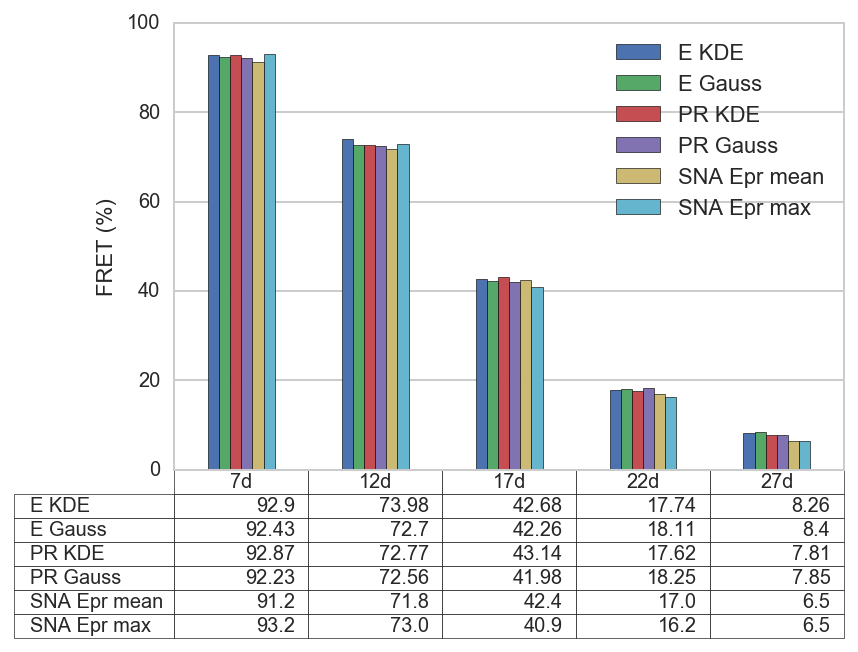

In [30]:
E.plot.bar(table=np.round(E, 2).T)
plt.ylabel('FRET (%)')
plt.gca().xaxis.set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Max error E_alex vs E_corr_pr: 1.21
Max error E_alex vs E_beta:    1.42
Max error E_beta vs E_corr_pr: 1.16


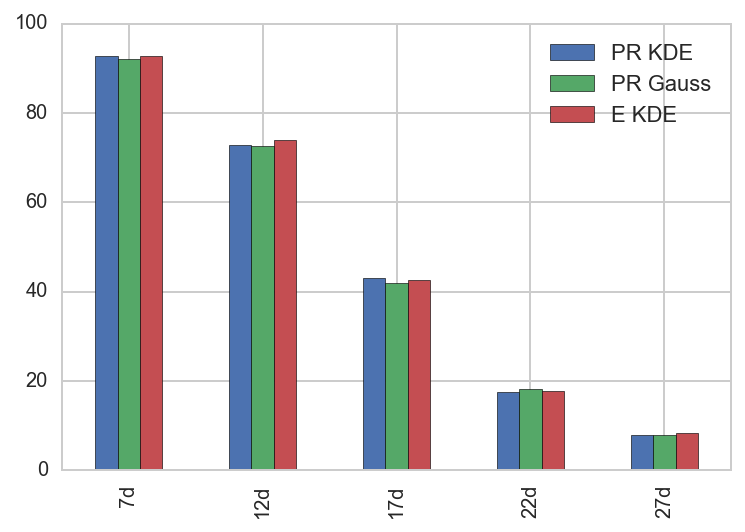

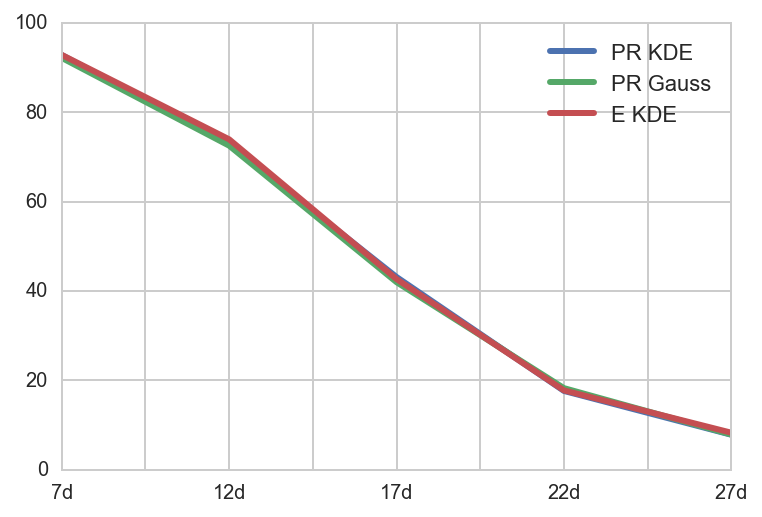

In [31]:
E[['PR KDE', 'PR Gauss', 'E KDE']].plot(kind='bar')
E[['PR KDE', 'PR Gauss', 'E KDE']].plot(lw=3);
print('Max error E_alex vs E_corr_pr: %.2f' % (E['E KDE'] - E['PR KDE']).abs().max())
print('Max error E_alex vs E_beta:    %.2f' % (E['E KDE'] - E['PR Gauss']).abs().max())
print('Max error E_beta vs E_corr_pr: %.2f' % (E['PR Gauss'] - E['PR KDE']).abs().max())

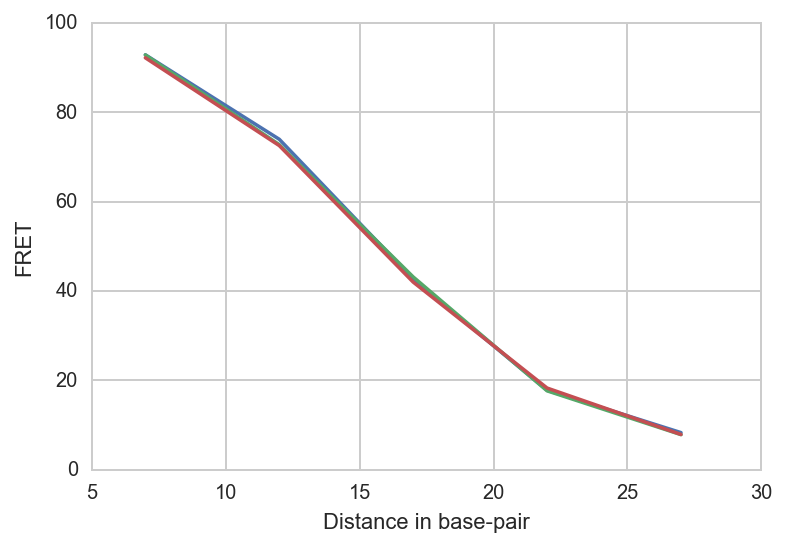

In [32]:
x = [int(idx[:-1]) for idx in out.index]
plt.plot(x, 'E KDE', data=E)
plt.plot(x, 'PR KDE', data=E)
plt.plot(x, 'PR Gauss', data=E)
plt.xlabel('Distance in base-pair')
plt.ylabel('FRET');

In [33]:
E['E KDE'] - E['PR KDE']

7d     0.026698
12d    1.206923
17d   -0.460290
22d    0.118158
27d    0.452226
dtype: float64

> **NOTE:** Fitting $d_{dirT}$ to match $E$ from corrected hsitograms with $E$ from PR correction formula produces a max difference of 1% for the 12d sample. The match is well below the fitting accuracy (> 2%).

# Save

In [34]:
E.to_csv('results/usALEX-5samples-E-all-methods.csv')

In [35]:
E

,E KDE,E Gauss,PR KDE,PR Gauss,SNA Epr mean,SNA Epr max
7d,92.90,92.4307,92.873302,92.225478,91.2,93.2
12d,73.98,72.7043,72.773077,72.560799,71.8,73.0
17d,42.68,42.2624,43.140290,41.983996,42.4,40.9
22d,17.74,18.1067,17.621842,18.247880,17.0,16.2
27d,8.26,8.3971,7.807774,7.848009,6.5,6.5
